## How to pull elevation data from the National Map WCS Services 

by: Colin Talbert 2018-11-14

In [1]:
%matplotlib inline

import owslib
from owslib.wcs import WebCoverageService

In [2]:
owslib.__version__

'0.17.0'

#### Connect to the service and take a look at it's contents

In [3]:
wcs=WebCoverageService('https://elevation.nationalmap.gov:443/arcgis/services/3DEPElevation/ImageServer/WCSServer',version='1.0.0')
# Take a look at the contents (coverages) of the wcs.

for k, v in wcs.contents.items():
    print(k, ": ", v)

DEP3ElevationPrototype :  <owslib.coverage.wcs100.ContentMetadata object at 0x000001F4C96B0198>
DEP3ElevationPrototype_Hillshade Gray :  <owslib.coverage.wcs100.ContentMetadata object at 0x000001F4C96B08D0>
DEP3ElevationPrototype_Aspect Degrees :  <owslib.coverage.wcs100.ContentMetadata object at 0x000001F4C96B0A90>
DEP3ElevationPrototype_Aspect Map :  <owslib.coverage.wcs100.ContentMetadata object at 0x000001F4C96B0A20>
DEP3ElevationPrototype_GreyHillshade_elevationFill :  <owslib.coverage.wcs100.ContentMetadata object at 0x000001F4C96B02B0>
DEP3ElevationPrototype_Hillshade Multidirectional :  <owslib.coverage.wcs100.ContentMetadata object at 0x000001F4C96B0080>
DEP3ElevationPrototype_Slope Map :  <owslib.coverage.wcs100.ContentMetadata object at 0x000001F4C96B0048>
DEP3ElevationPrototype_Slope Degrees :  <owslib.coverage.wcs100.ContentMetadata object at 0x000001F4C96B0BE0>
DEP3ElevationPrototype_Hillshade Elevation Tinted :  <owslib.coverage.wcs100.ContentMetadata object at 0x000001F

In [4]:
elev=wcs['DEP3ElevationPrototype']

output = wcs.getCoverage(identifier='DEP3ElevationPrototype', bbox=(-180,0,0,90), format='GeoTIFF', resx=0.1, resy=0.1, crs=4326)
contents = output.read()

### contents here are a geotiff written out as a string.
here's some things we can do with this

### 1) Save it out to a file

In [5]:
f=open('elevation.tif','wb')
f.write(contents)
f.close()

### 2) load it directly into a rasterio layer

In [6]:
import rasterio
from rasterio.io import MemoryFile
elev = MemoryFile(contents).open()

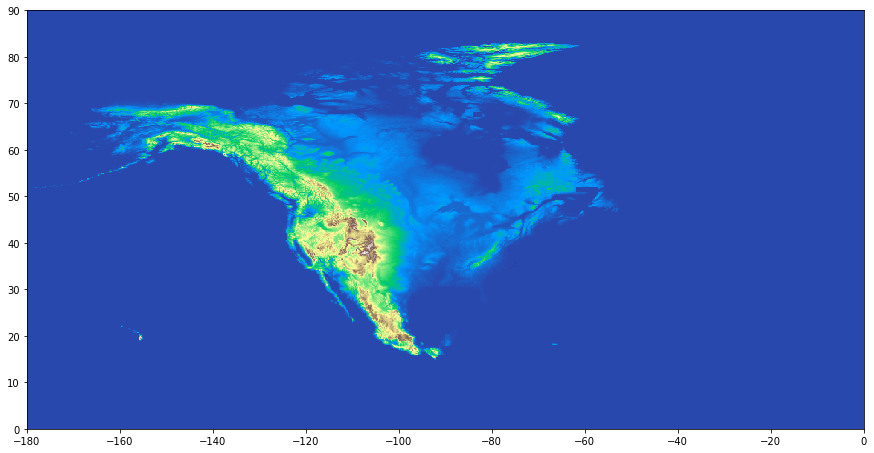

In [7]:
from matplotlib import pyplot as plt
from rasterio import plot

fig, ax = plt.subplots(1, 1, figsize=(15,25))
plot.show(elev, ax=ax, cmap=plt.cm.terrain)

In [8]:
elev.shape

(900, 1800)

### 3) get a numpy array of the data (from the rasterio memfile)

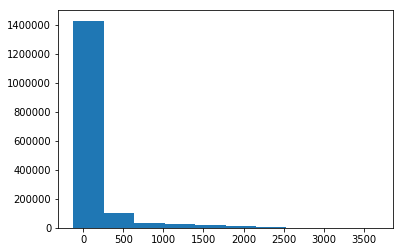

In [9]:
data = elev.read(1)

plt.hist(data.flatten())  # arguments are passed to np.histogram
plt.show()


## What do the other layers look like?

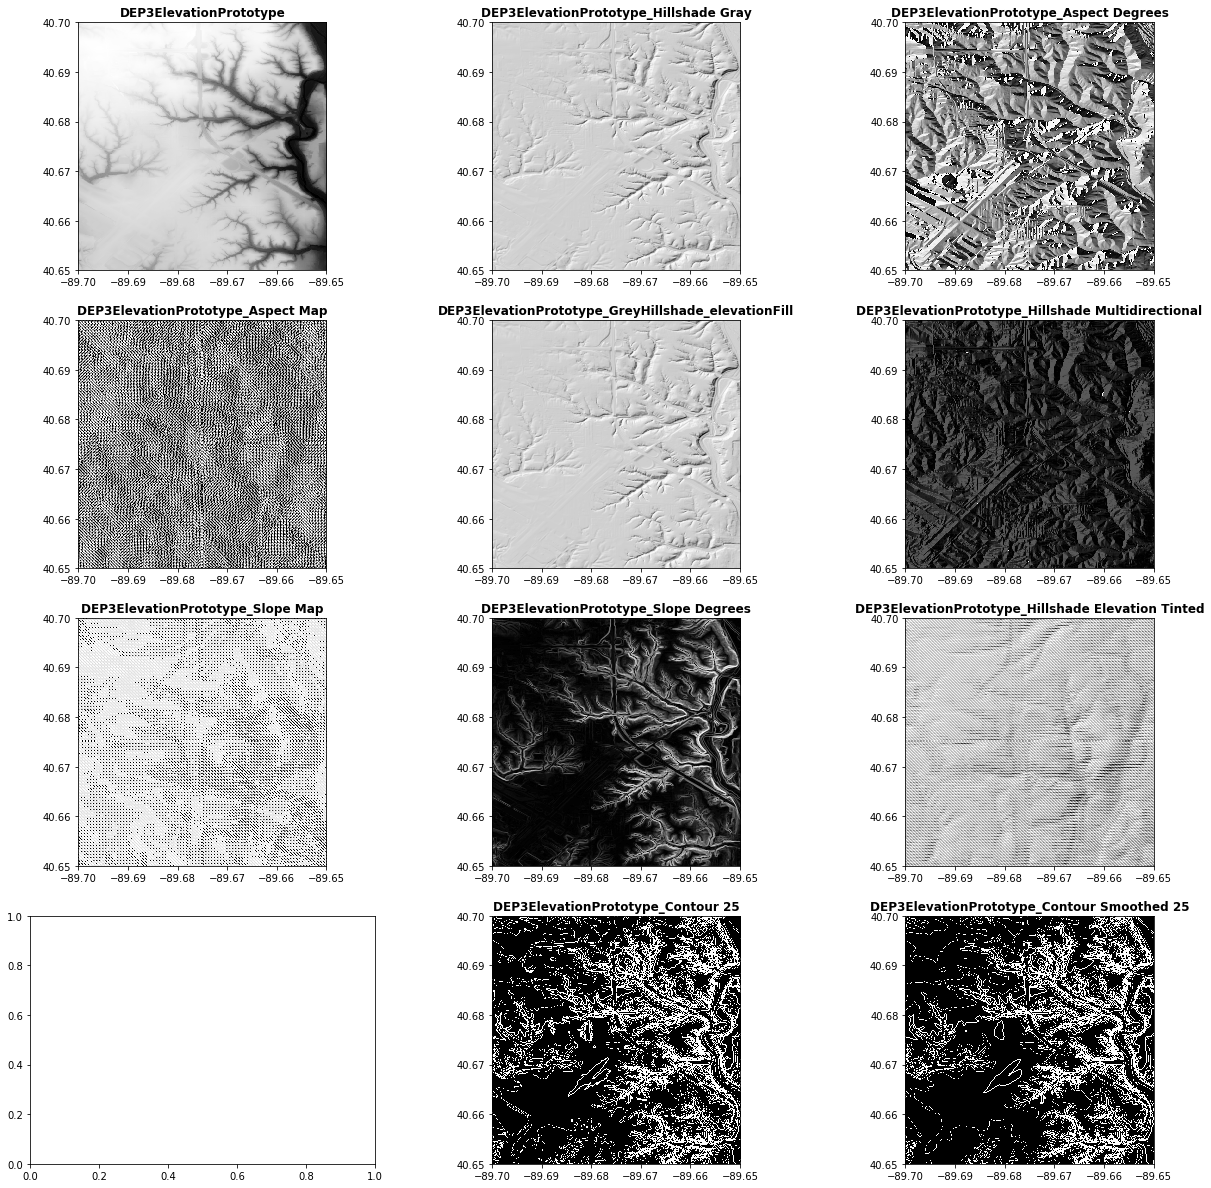

In [10]:

fig, axes = plt.subplots(4,3, figsize=(21,21))

i = 0
for k, v in wcs.contents.items():
    try:
        output = wcs.getCoverage(identifier=k, bbox=(-89.7, 40.65, -89.65, 40.7), format='GeoTIFF', resx=0.0001, resy=0.0001, crs=4326)
        contents = output.read()

        layer = MemoryFile(contents).open()
    
        plot.show(layer, ax=axes.flatten()[i], title=k, cmap='Greys_r')
    except:
        pass
    i += 1

### How does this service return data match the values we would get if we downloaded an actual tile?

In [11]:
# this is a 1 arc second tile I downloaded for the grand canyon from the National Map
truth = rasterio.open(r"C:\Users\talbertc\Downloads\USGS_NED_1_n37w113_GridFloat\usgs_ned_1_n37w113_gridfloat.flt")
truth_data = truth.read(1)

##### We need to take a subset since the service won't allow downloading a full tile's worth of data

In [12]:
# this is the resolution for 1 arc second (30m DEM)
res = 0.00027777777803598

In [13]:
left, bottom, right, top =list(truth.bounds)

# A subset size for our comparison
pixels = 400

x_offset, y_offset = 3000, 3000

offset_left = left + x_offset * res
offset_top = top - y_offset * res

right = offset_left + pixels * res
bottom = offset_top - pixels * res

truth_subset = truth_data[ y_offset:y_offset+pixels, x_offset:x_offset+pixels]


##### Download from the service a matching extent

In [14]:
elev=wcs['DEP3ElevationPrototype']

output=wcs.getCoverage(identifier='DEP3ElevationPrototype', bbox=(offset_left, bottom, right, offset_top), format='GeoTIFF', resx=res, resy=res, crs=4326)

# Write the file out to disk.
data = output.read()
f=open('service_return2.tif','wb')
f.write(data)
f.close()

service = rasterio.open("service_return2.tif")
service_data = service.read(1)

service.close()

In [15]:
diff  = truth_subset - service_data

##### Plot out these four versions

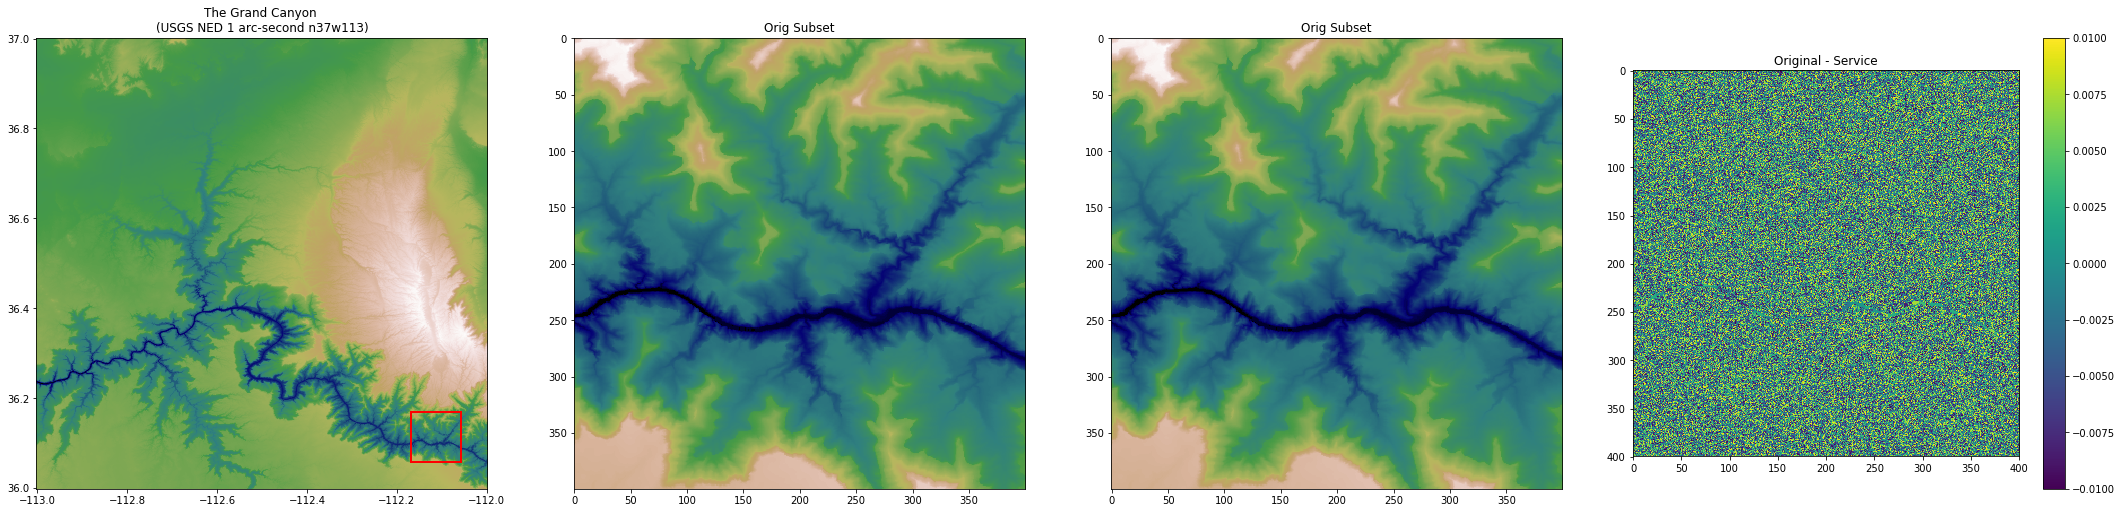

In [16]:
fig, axes = plt.subplots(1,4, figsize=(30, 7))

orig, orig_subset, service, diff_plot = axes.flatten()

orig.imshow(truth_data, interpolation='nearest', cmap=plt.cm.gist_earth, extent=plot.plotting_extent(truth))
orig.plot([offset_left, right], [offset_top, offset_top],  'k-', lw=2, c='red')
orig.plot([right, right], [offset_top, bottom],  'k-', lw=2, c='red')
orig.plot([offset_left, right], [bottom, bottom],  'k-', lw=2, c='red')
orig.plot([offset_left, offset_left], [bottom, offset_top],  'k-', lw=2, c='red')
orig.set_title('The Grand Canyon \n(USGS NED 1 arc-second n37w113)')

orig_subset.imshow(truth_subset, interpolation='nearest', cmap=plt.cm.gist_earth)
orig_subset.set_title('Orig Subset')

service.imshow(service_data, interpolation='nearest', cmap=plt.cm.gist_earth)
service.set_title('Orig Subset')

diff_data  = truth_subset - service_data
diff_im = diff_plot.imshow(diff_data)
diff_plot.set_title('Original - Service')
plt.colorbar(diff_im);

plt.tight_layout()

The difference between pixel values from a downloaded tile and the service return are small (< 0.01 meters), and randomly distributed.  
### It works!